In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv("tips.csv")

In [3]:
df.head()

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244 entries, 0 to 243
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   total_bill  244 non-null    float64
 1   tip         244 non-null    float64
 2   sex         244 non-null    object 
 3   smoker      244 non-null    object 
 4   day         244 non-null    object 
 5   time        244 non-null    object 
 6   size        244 non-null    int64  
dtypes: float64(2), int64(1), object(4)
memory usage: 13.5+ KB


In [5]:
df.describe()

,total_bill,tip,size
count,244.000000,244.000000,244.000000
mean,19.785943,2.998279,2.569672
std,8.902412,1.383638,0.951100
min,3.070000,1.000000,1.000000
25%,13.347500,2.000000,2.000000
50%,17.795000,2.900000,2.000000
75%,24.127500,3.562500,3.000000
max,50.810000,10.000000,6.000000


In [6]:
df.columns

Index(['total_bill', 'tip', 'sex', 'smoker', 'day', 'time', 'size'], dtype='object')

In [7]:
cat_cols = ['sex', 'smoker', 'day', 'time']
num_cols = ['total_bill', 'tip']

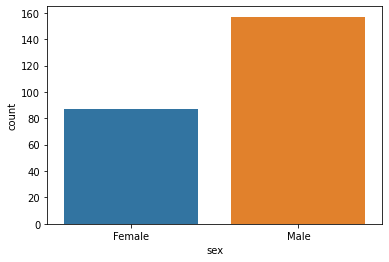

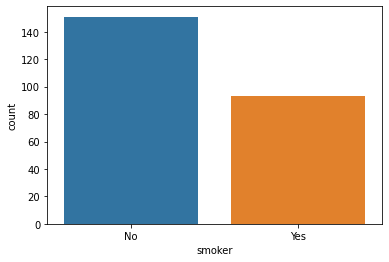

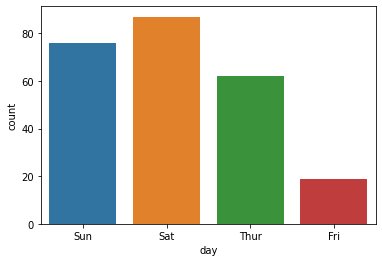

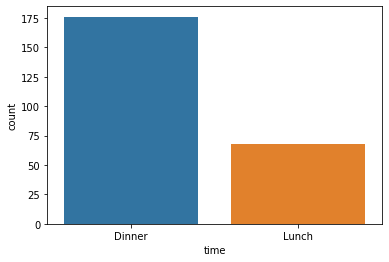

In [8]:
for i in cat_cols:
    sns.countplot(x=df[i])
    plt.show()

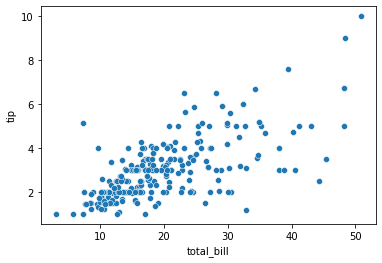

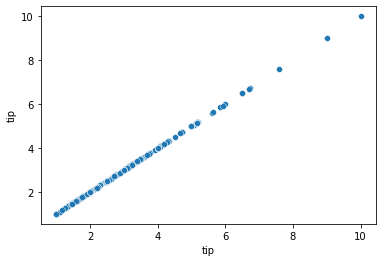

In [9]:
for i in num_cols:
    sns.scatterplot(x=df[i], y=df["tip"])
    plt.show()

<AxesSubplot:>

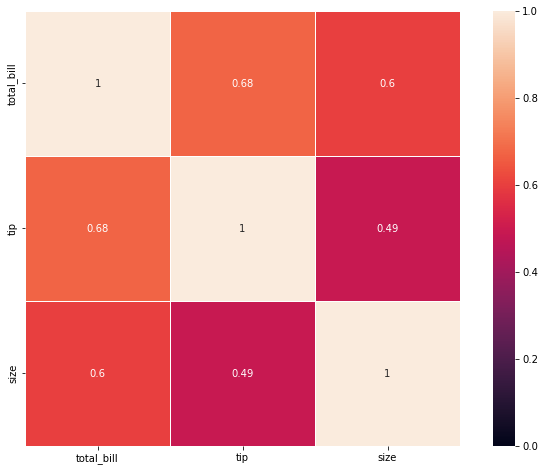

In [10]:
corr = df.corr()

f, ax = plt.subplots(figsize=(12, 8))
sns.heatmap(corr,linewidths=.5, vmin=0, vmax=1, square=True, annot=True)

total_bill skewness: 1.1332130376158205



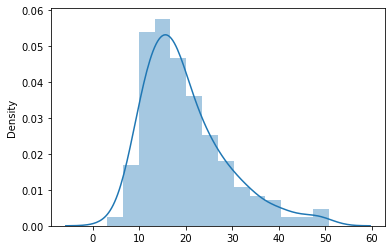

tip skewness: 1.4654510370979401



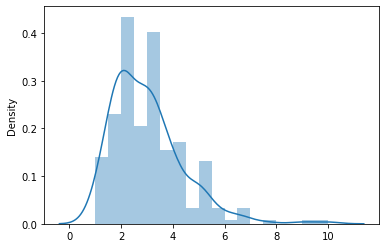

In [11]:
for i in df.iloc[:, 0:2]:
    print(f"{i} skewness: {df[i].skew()}\n")
    sns.distplot(x=df[i])
    plt.show()

In [12]:
y = df["tip"]
X = df.drop("tip", axis=1)

In [13]:
from sklearn.model_selection import train_test_split
X_train_full, X_test_full, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

In [14]:
categorical_cols = [i for i in X_train_full.columns if X_train_full[i].dtype == "object"]
numerical_cols =  [i for i in X_train_full.columns if X_train_full[i].dtype in ['float64', "int64"]]

In [15]:
my_cols = categorical_cols + numerical_cols
X_train = X_train_full[my_cols].copy()
X_test = X_test_full[my_cols].copy()

In [16]:
X_train.head()

,sex,smoker,day,time,total_bill,size
197,Female,Yes,Thur,Lunch,43.11,4
139,Female,No,Thur,Lunch,13.16,2
241,Male,Yes,Sat,Dinner,22.67,2
75,Male,No,Sat,Dinner,10.51,2
127,Female,No,Thur,Lunch,14.52,2


In [17]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import OneHotEncoder

numerical_transformer = MinMaxScaler()

categorical_transformer = OneHotEncoder(handle_unknown="ignore")

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numerical_transformer, numerical_cols),
        ("cat", categorical_transformer, categorical_cols)
    ])

In [18]:
preprocessor

ColumnTransformer(transformers=[('num', MinMaxScaler(), ['total_bill', 'size']),
                                ('cat', OneHotEncoder(handle_unknown='ignore'),
                                 ['sex', 'smoker', 'day', 'time'])])

In [19]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.model_selection import cross_val_score

In [20]:
def get_score(n_estimators):
    """Return the average MAE over 3 CV folds of random forest model.
    
    Keyword argument:
    n_estimators -- the number of trees in the forest
    """
    my_pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', RandomForestRegressor(n_estimators, random_state=0))
    ])
    scores = -1 * cross_val_score(my_pipeline, X_train, y_train,
                                  cv=3,
                                  scoring='neg_mean_absolute_error')
    return scores.mean()

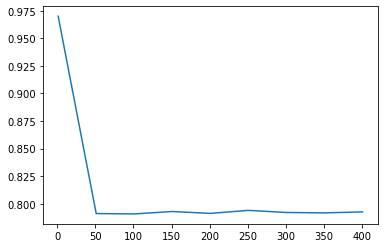

In [21]:
results = {} # Your code here
for i in range(1,450,50):
    results[i] = get_score(i)
    
plt.plot(list(results.keys()), list(results.values()))
plt.show()

In [22]:
model_1 = RandomForestRegressor(n_estimators=5, random_state=0)
model_2 = LinearRegression()
model_3 = DecisionTreeRegressor(random_state=0)
model_4 = SVR(kernel="linear", C=10)

In [23]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

pipe_rfc = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("model_rfc", model_1)
    ])

pipe_lr = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("model_lr", model_2)
    ])

pipe_dtr = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("model_lr", model_3)
    ])

pipe_svr = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("model_svr", model_4)
    ])

pipes = {"RFC":pipe_rfc, "LR":pipe_lr, "DTR ":pipe_dtr, "SVR":pipe_svr}

In [24]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=5)

for i in pipes.keys():
    score = cross_val_score(pipes[i], X_train, y_train, cv=kf, scoring="r2", error_score="raise")
    print(f"Model {i}: {score.mean()}")

Model RFC: 0.2399673184455134
Model LR: 0.3793978627600108
Model DTR : 0.15926405582771294
Model SVR: 0.3782492091653614


# Test

In [25]:
def score_mae(model, X_t=X_train, X_v=X_test, y_t=y_train, y_v=y_test):
    model.fit(X_t, y_t)
    preds = model.predict(X_v)
    return mean_absolute_error(y_v, preds)

def score_r2(model, X_t=X_train, X_v=X_test, y_t=y_train, y_v=y_test):
    model.fit(X_t, y_t)
    preds = model.predict(X_v)
    return r2_score(y_v, preds)

def score_rmse(model, X_t=X_train, X_v=X_test, y_t=y_train, y_v=y_test):
    model.fit(X_t, y_t)
    preds = model.predict(X_v)
    return np.sqrt(mean_squared_error(y_v, preds))

for i in pipes:
    mae = score_mae(pipes[i])
    r2 = score_r2(pipes[i])
    rmse = score_rmse(pipes[i])
    print(f"Model {i} MAE: {mae}\nModel {i} R2: {r2}\nModel {i} RMSE: {rmse}\n")

Model RFC MAE: 0.9601621621621621
Model RFC R2: -0.31428152530878917
Model RFC RMSE: 1.2673694825919573

Model LR MAE: 0.7129320207316268
Model LR R2: 0.3368130367187452
Model LR RMSE: 0.9002788220824843

Model DTR  MAE: 0.8954054054054055
Model DTR  R2: -0.11306380867212495
Model DTR  RMSE: 1.1663236303920157

Model SVR MAE: 0.6950523855001552
Model SVR R2: 0.3809397497328405
Model SVR RMSE: 0.8698122170572372



In [26]:
import sklearn
sorted(sklearn.metrics.SCORERS.keys())

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'jaccard',
 'jaccard_macro',
 'jaccard_micro',
 'jaccard_samples',
 'jaccard_weighted',
 'max_error',
 'mutual_info_score',
 'neg_brier_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_absolute_percentage_error',
 'neg_mean_gamma_deviance',
 'neg_mean_poisson_deviance',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'neg_root_mean_squared_error',
 'normalized_mutual_info_score',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'rand_score',
 'recall',
 'recall_macro',
 'recall_micro',
 'recall_samples',
 'recall_weighted',
 'roc_auc',
 'roc_auc_ovo',
 'roc_auc_ovo_weighted',
 'roc_auc_ovr',
 'roc_auc_ovr_we

In [27]:
pipe_svr.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'preprocessor', 'model_svr', 'preprocessor__n_jobs', 'preprocessor__remainder', 'preprocessor__sparse_threshold', 'preprocessor__transformer_weights', 'preprocessor__transformers', 'preprocessor__verbose', 'preprocessor__verbose_feature_names_out', 'preprocessor__num', 'preprocessor__cat', 'preprocessor__num__clip', 'preprocessor__num__copy', 'preprocessor__num__feature_range', 'preprocessor__cat__categories', 'preprocessor__cat__drop', 'preprocessor__cat__dtype', 'preprocessor__cat__handle_unknown', 'preprocessor__cat__sparse', 'model_svr__C', 'model_svr__cache_size', 'model_svr__coef0', 'model_svr__degree', 'model_svr__epsilon', 'model_svr__gamma', 'model_svr__kernel', 'model_svr__max_iter', 'model_svr__shrinking', 'model_svr__tol', 'model_svr__verbose'])

In [28]:
param_grid = {
    "model_svr__kernel":("rbf","linear"),
    "model_svr__C":[1,10,100]
}

In [29]:
from sklearn.model_selection import GridSearchCV
grid_cv = GridSearchCV(pipe_svr, cv=3, param_grid=param_grid)
grid_cv.fit(X_train, y_train)
print("Best: %f using %s" % (grid_cv.best_score_, grid_cv.best_params_))

Best: 0.427027 using {'model_svr__C': 10, 'model_svr__kernel': 'rbf'}
